<h1>PREDICTING HOUSE VALUES</h1>

The U.S.A. has a decennial census which provides information about households across the country. This data will be used to build a model that is capable of predicting median house values. The dataset being used contains demographic and geographic information on 20,640 locations across the state and has the following attributes:
<br><br>

| Variable | Description | Unit |
| -------- | ----------- | ---- |
| Longitude        | longitude of location | numeric |
| Latitude         | latitude of location | numeric |
| housingMedianAge | median age of housing at location | years |
| totalRooms       | number of rooms at location | integer |
| totalBedrooms    | number of bedrooms at location | integer |
| population       | number of individuals living at location | integer |
| households       | number of independent households at location | integer |
| medianIncome     | median income of households | 10K dollars |
| medianHouseValue | median value of housing at location | 1K dollars |

<br><br>
Now let us load the data into a data frame and take our first look.
<br><br>

<h2>Loading the data</h2>

In [1]:
#Importing necessary packages
import os
import pandas as pd
from six.moves import urllib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, cross_val_score, GridSearchCV
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import Imputer, LabelBinarizer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

#Loading dataset
housing = pd.read_csv('housing.csv')

<h2>Taking a look at the data</h2>

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The data seems to have loaded successfully. As previously mentioned, the dataset contains entries for 20, 640 locations. However, the `total_bedrooms` attribute only has 20, 433 non-null values which means that 207 entries are missing data for this feature. This is something that needs to be taken care of before conducting analysis.

It's now known what kind of data the dataset holds. Now let's take a deeper look by summarizing all the numerical attributes.
<br><br>

In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The previous error is a result of the missing values in `total_bedrooms` mentioned earlier. This can be safely ignored for now. To further get a feel for the numerical data, each attribute is plotted on a historgram and taken a look at.
<br><br>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015D31DD4A90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000015D32395F28>]], dtype=object)

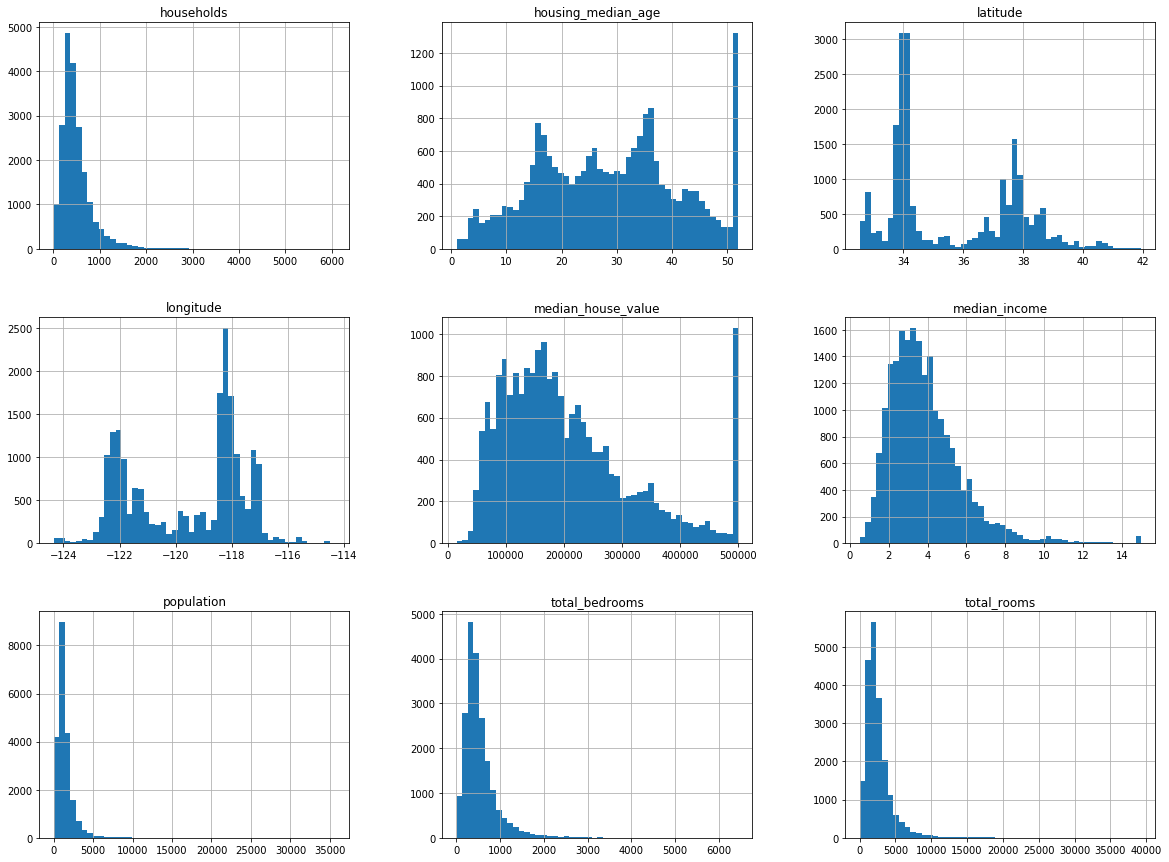

In [5]:
housing.hist(bins=50, figsize=(20, 15))

Taking a look at `housing.describe()` and the histograms, a few observations can be made:
<br><br>
1. There are huge spikes towards the end of the histograms for `housing_median_age` and `median_house_value` as well as a small spike towards the end of `median_income`. Not to mention their max values seem to be nicely rounded off. This is a sign this data was likely scaled and capped. In the case of `median_house_value` which is our target attribute this could be a serious problem as our model would learn from this data that prices will never go above this limit which is not the case in real life. As a result if it is asked to predict the value of a house with a value higher than this it will not be able to.
<br><br>
2. These attributes have different scales and will need to undergo feature scaling.
<br><br>
3. The distributions observed in many of these histograms are tail heavy, i.e. they extend farther to the right of the median than to the left which can be unsuitable for some Machine Learning Algorithms. This can be handled using standardization to change the distribution to be more bell-shaped.
<br><br>
Next, it can be seen that there is one non-numerical attribute called `ocean_proximity`.
<br><br>

In [6]:
print(housing["ocean_proximity"].value_counts())

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64


As can be seen it is a categorical attribute with 5 possible values.

Now that the data has been observed, before taking an even deeper look, the data needs to be split into training and test sets. After this observations and analysis will be conducted only on the training set to avoid data snooping bias.
<br><br>

<h2>Creating the Test and Training sets</h2>
<br><br>
Since the dataset is not very large, it is a good idea to use stratified sampling when creating the test set so as to avoid sampling bias and to guarantee that the test set is representative of the overall population.
<br><br>

In [7]:
housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Looking at the correlation between the target attribute and other attributes, it can be observed that `median_income` is the most important to predict `median_house_value`. To ensure that the test set is representative of various categories of incomes in the whole dataset, it would be a good idea to create an `income_cat` attribute that represents `median_income` as a categorical attribute and use it for stratified shuffling.
<br><br>

In [8]:
#Divide by 1.5 to limit the number of categories
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
#Label those above category as category 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace = True)

#Now we can use Scikit-Learns StratifiedShuffleSplit class to do stratified sampling on the income category.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#Setting random state ensures results are reproducible

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

With this a stratified training and test set have been generated. To understand the effect of stratified sampling let's conduct another split using random sampling and compare the results.
<br><br>

In [9]:
#Returns income category proportions for each category
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

#Generate test set using random sampling
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

#Create data frame to compare income category proportions
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

#Add % error for random and stratified sampling for further comparison
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


As can be seen from the above table, the proportions seen in stratified sampling are very close to that of the entire data set. That maximum absolute error for stratified sampling is 0.243309 while for random sampling it is 5.056334. The high error rate is a result of a skewed test set produced by random sampling, which is why stratified sampling is preferrable in this case.

Now that the test set has been generated, the `income_cat` attribute is not longer necessary and can be dropped.
<br><br>

In [10]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

<h2>Visualizing Data to Gain Insights</h2>
<br><br>
To go even more in depth to understand the data, the next step is to visualize it in various ways and observe these visualizations to identify trends, patterns and gain insights.
<br><br>

In [11]:
housing = strat_train_set.copy() #taking  a copy of the training set for visualization

Since there is geographical information it is a good idea to create a scatterplot of all districts to visualize the data.
<br><br>

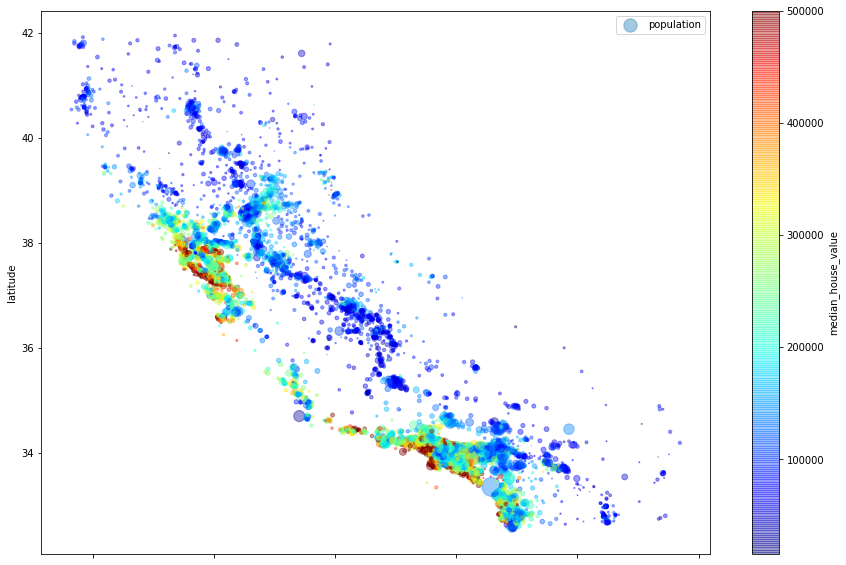

In [12]:
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(15, 10), alpha = 0.4, s=housing["population"]/100, label="population", c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()

Looking at this plot, it can be observed that house prices are related to `population` (represented by radii of the circles) as well as `ocean_proximity` (higher prices in areas closer to the ocean). While `ocean_proximity` does seem to be a useful attribute, it doesn't seem to be a consistent rule as prices in northern coastal districts don't seem to be as high as in the south.

Earlier, the correlations between all the attributes and the target attribute were observed. It is possible to observe to correlation between pairs of all attributes using the correlation matrix. To further assist observation, the correlation matrix can be visualized on a heat map.
<br><br>

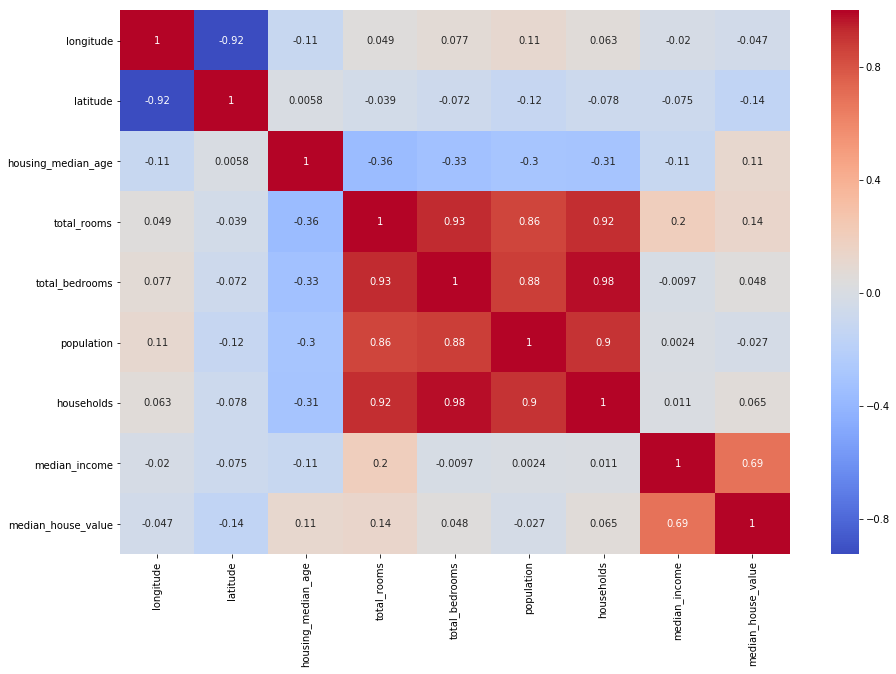

In [13]:
corr_matrix = housing.corr()
fig = plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

Looking at this matrix, certain promising attributes that have higher correlations with the target attribute are selected to plot a scatter matrix for further observation.
<br><br>

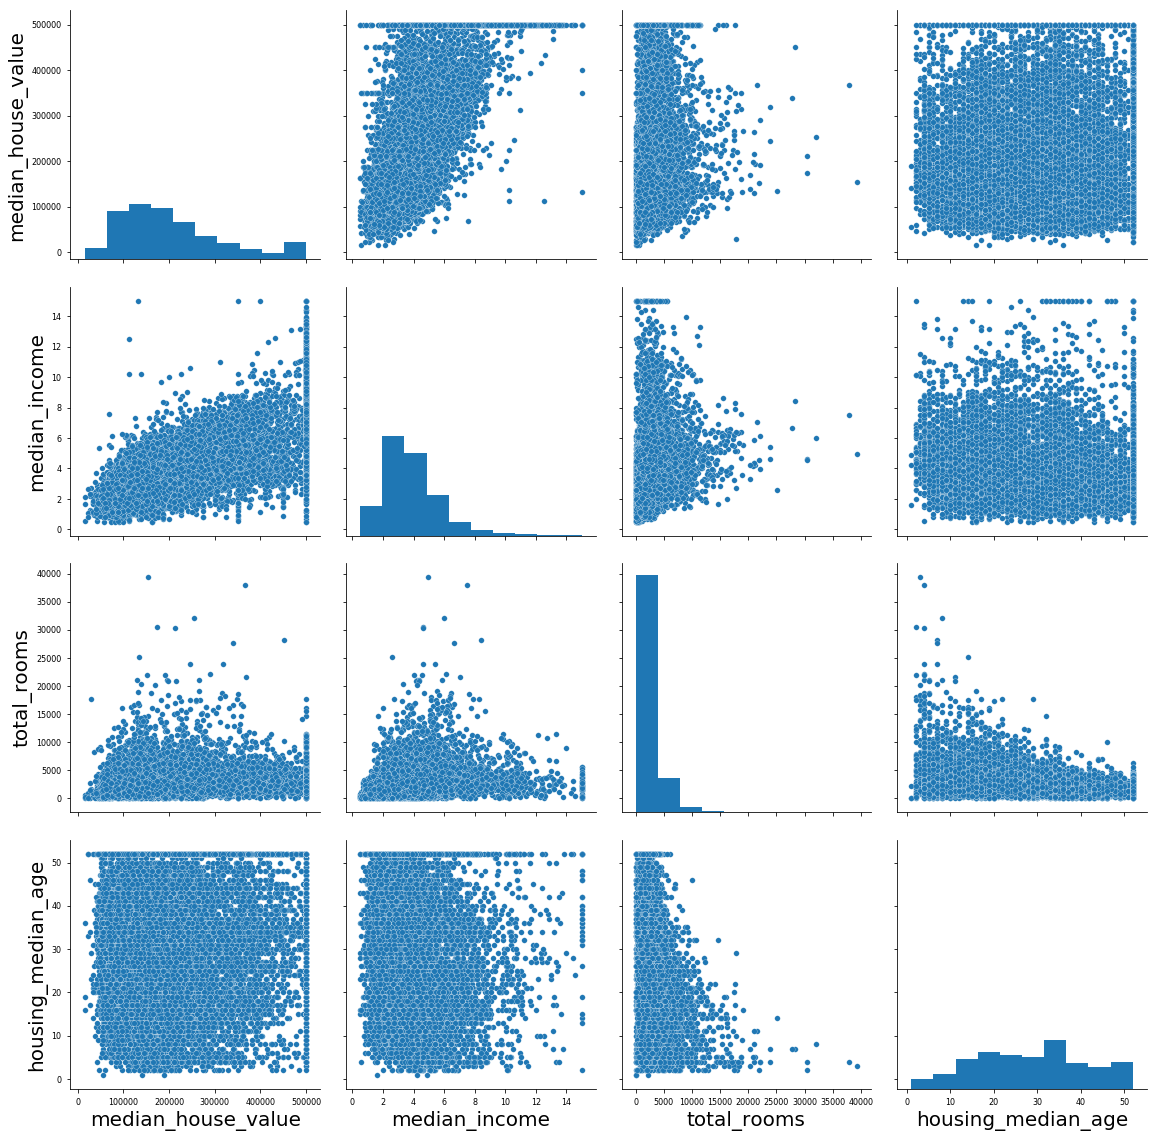

In [14]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
sns.set_context("paper", rc={"axes.labelsize":20})   
sns.pairplot(housing[attributes], size=4)

We've observed before that the most promising feature to predict `median_house_value` is `median_income`. Let's take a closer look at the correlation scatterplot between the two.
<br><br>

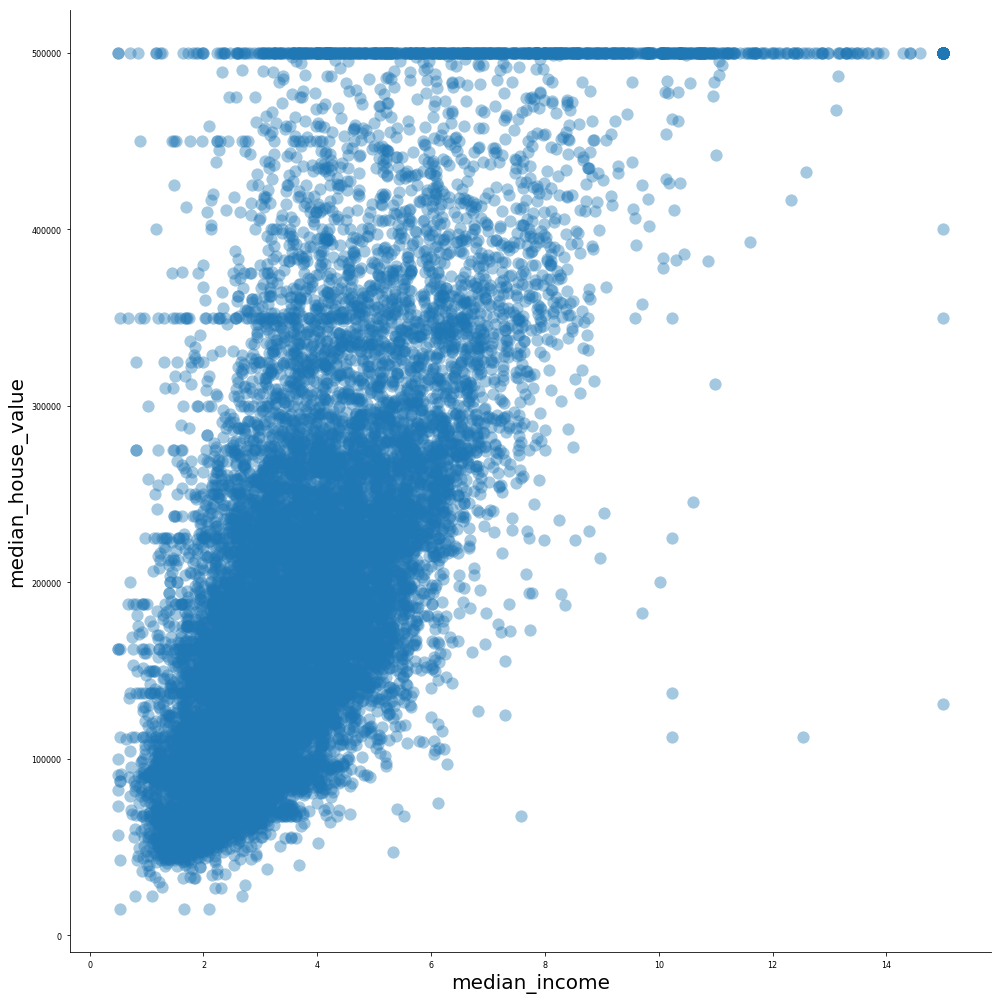

In [15]:
sns.lmplot(
    'median_income', 
    'median_house_value', 
    data=housing, 
    fit_reg=False, 
    size=14, 
    scatter_kws={"marker": "D", "s": 150, "alpha": 0.4}
)

From the plot a strong correlation between the two attributes can be observed with the upwards trend and the close proximity between all the points. Also, the cap imposed on `median_house_value` that was mentioned previously is now clearly visible here in this plot.

Now that the data features and their correlations have been observed, before passing the data to a Machine Learning Algorithm, addition features that could be useful and have good correlation with the target attribute can be added by combining current attributes through feature engineering.

Knowing the total number of rooms in a district doesn't sound like it might be a good attribute for predicting the value of an individual house. However, total rooms per household could be more useful.

Similarly, by calculating the ratio of total bedrooms to total rooms in a district, we might get an idea of the size of houses in a district. Bigger luxurious houses would have a lower bedroom to room ratio while smaller houses would have a higher ratio.

Another attribute that could be useful is population per household. Let's add these attributes to the data and check their correlation with the target attribute.

In [16]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

We can observe that the added attributes are much more correlated with the target attribute compared to their constituent attributes. Now let's get the ready data for Machine Learning Algorithms.
<br><br>

<h2>Preparing the Data for Machine Learning Algorithms</h2>
<br><br>
Firstly, we split the training data labels (target attribute) from the training set as they need to undergo different transformations in different pipelines.

In [17]:
housing_labels = housing["median_house_value"].copy()
housing.drop("median_house_value", axis=1, inplace=True)

Now, the pipelines can be created to transform the data by performing three tasks on them:

1. <b>Data Cleaning:</b> As mentioned earlier the `total_bedrooms` attribute had missing values in certain rows. Giving the context of the data, the missingness of the data in this attribute most likely doesn't have any correlation to the target attribute. Hence, an `Imputer` is used to fill in missing values with the median of the column.
<br><br>
2. <b>Handling Text and Categorical Attributes:</b> Since most ML algorithms work better with numbers instead of text, so it's preferable to convert `ocean_proximity` to a numerical attribute. A `LabelBinarizer` is used to convert the text entries to one-hot vectors.
<br><br>
3. <b>Feature Scaling:</b> Most ML algorithms require numerical attributes to have the same scale. The numerical attributes are standardized using `StandardScaler`.

Since text and numerical categories undergo different transformations in different pipelines, they need to be separated.
<br><br>

In [18]:
housing_num = housing.drop("ocean_proximity", axis=1)

num_attribs = list(housing_num)     #List of numerical attributes
cat_attribs = ["ocean_proximity"]   #List of categorical attributes


Each subpipeline will start with a selector transformer which transforms the data by selecting the desired attributes, dropping the rest and converting the resulting DataFrame to a NumPy array since Scikit-Learn classes can't handle DataFrames.
<br><br>

In [19]:
class DataFrameSelector(BaseEstimator, TransformerMixin): #selector transformer that transforms the data by selecting only desired attributes and converting to a NumPy array
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names].values

The numerical pipeline applies the `Imputer` and `StandardScaler` classes to numerical attributes.
<br><br>

In [20]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

The categorical pipeline applies the `LabelBinarizer` class to categorical attributes.
<br><br>

In [21]:
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer()),
])

These two pipelines are combined using Scikit-Learn's `FeatureUnion` class.
<br><br>

In [22]:
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

With the full pipeline ready, the data can finally be prepared for ML algorithms.
<br><br>

In [23]:
housing_prepared = full_pipeline.fit_transform(housing)

housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

While all the data can't be seen, it can be verified that the first three attributes now share the same scale, while the last two attributes are part of the one-hot vector that the text attribute was converted to. Now it's time to feed this data to a Machine Learning Model.
<br><br>

<h2>Training, Evaluating and Tuning the Machine Learning Model</h2>
<br><br>
Now that the data has been prepared, it can be tested with multiple Machine Learning Models. For this project, the following three models will be used and their performance compared:
1. Linear Regression Model
<br><br>
2. Decision Tree Regressor
<br><br>
3. Random Forest Regressor
<br><br>
The models will are first fitted with the training data. Then they are tested and evaluated multiple times using different subsets of the training data through K-fold cross-validation. Then their performance scores, which are calculated during this process, will be used to compare the performance of the different models. The models will also be scored with the complete training set, and compared against performance with the validation set scores to check to see if there is any overfitting.
<br><br>

In [24]:
#Displays k evaluation scores, their mean and standard deviation
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

#Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

#Decision Tree Regressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

#Random Forest Regressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

Linear Regression Train Score:

In [25]:
lin_rmse

68161.226444331987

Linear Regression Validation Scores:

In [26]:
display_scores(lin_rmse_scores)

Scores:  [ 66060.65470195  66764.30726969  67721.72734022  74719.28193624
  68058.11572078  70909.35812986  64171.66459204  68075.65317717
  71024.84033989  67300.24394751]
Mean:  68480.5847155
Standard deviation:  2845.58430927


Decision Tree Regressor Train Score:

In [27]:
tree_rmse

0.0

Decistion Tree Regressor Validation Scores:

In [28]:
display_scores(tree_rmse_scores)

Scores:  [ 70641.5288137   69054.04794313  70894.72565645  69782.6228843
  70299.20237758  74885.93873291  71835.0509335   70278.46383945
  75176.53428031  71438.51134291]
Mean:  71428.6626804
Standard deviation:  1949.77168461


Random Forest Regressor Train Score:

In [29]:
forest_rmse

22205.270830755482

Random Forest Regressor Validation Scores:

In [32]:
display_scores(forest_rmse_scores)

Scores:  [ 51445.52504401  49712.55703254  52883.45804931  54794.23069617
  51426.91490907  56206.08365334  51575.58796236  49714.08326236
  54709.30361768  52829.6916804 ]
Mean:  52529.7435907
Standard deviation:  2068.22629086


From the above results we can infer the following:

1. Decision Tree Regressor is overfitting terribly, having 0 RMSE error with the training set but an RMSE score of approximately 71428 ± 1949 with validation sets.
<br><br>
2. Linear Regression Model doesn't have a problem with overfitting, having similar RMSE scores for both training and validation sets. However, it offers a very small improvement in performance over Decision Tree Regressor with the validation sets, having a slightly lesser RMSE score of 68480 ± 2845 (training score of 68161).
<br><br>
3. Random Forest Regressor is a significant improvement over both of the previous models, boasting a validation RMSE score of 52529 ± 2068. However, with a training RMSE score of 22205, this model seems to be suffering from overfitting the training set as well.
<br><br>

Now that the best performing model has been identified, let's try to fine-tune it's performance by optimizing it's hyperparameters through performing Grid Search.

In [33]:
param_grid = [
    {'n_estimators': [3, 10, 30, 60, 90], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error")

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30, 60, 90], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

After trying out various combinations of hyperparameters and comparing performance, we can details of the best combination of parameters, the best estimator as well as cross validation evaluation scores.

Grid search best parameters:

In [34]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 90}

Grid search best estimator:

In [35]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Grid search evaluation scores:

In [36]:
gridcvres = grid_search.cv_results_
for mean_score, params in zip(gridcvres["mean_test_score"], gridcvres["params"]):
    print(np.sqrt(-mean_score), params)

63770.4748716 {'n_estimators': 3, 'max_features': 2}
55657.6289593 {'n_estimators': 10, 'max_features': 2}
52784.6111347 {'n_estimators': 30, 'max_features': 2}
52141.1566053 {'n_estimators': 60, 'max_features': 2}
51975.3496233 {'n_estimators': 90, 'max_features': 2}
59652.8645252 {'n_estimators': 3, 'max_features': 4}
52869.6385706 {'n_estimators': 10, 'max_features': 4}
50340.0393667 {'n_estimators': 30, 'max_features': 4}
49870.825241 {'n_estimators': 60, 'max_features': 4}
49817.9666008 {'n_estimators': 90, 'max_features': 4}
59140.8186029 {'n_estimators': 3, 'max_features': 6}
52159.9735941 {'n_estimators': 10, 'max_features': 6}
50339.0598266 {'n_estimators': 30, 'max_features': 6}
49334.6112927 {'n_estimators': 60, 'max_features': 6}
49232.4541653 {'n_estimators': 90, 'max_features': 6}
58002.9107599 {'n_estimators': 3, 'max_features': 8}
51662.5930873 {'n_estimators': 10, 'max_features': 8}
50102.7776652 {'n_estimators': 30, 'max_features': 8}
49431.9067648 {'n_estimators': 60

The best combination of hyperparameters is `{'max_features': 8, 'n_estimators': 90}` which has an RMSE score of 49175. Now that we have the best estimator, it can be inspected to gain more good insights. The `RandomForestRegressor` also calculates feature importance in making predictions. Looking at these scores, if certain features don't seem to be very useful they can be dropped which could lead to an improvement in performance.

In [37]:
feature_importances = grid_search.best_estimator_.feature_importances_

cat_one_hot_attribs = list(housing['ocean_proximity'].unique())
attributes = num_attribs +  cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(0.36588421318918923, 'median_income'),
 (0.16352681323781804, 'NEAR OCEAN'),
 (0.11270057053126216, 'population_per_household'),
 (0.066895668533995339, 'longitude'),
 (0.065834944352023389, 'bedrooms_per_room'),
 (0.060777621098220776, 'latitude'),
 (0.049722118141737534, 'rooms_per_household'),
 (0.043704591761532782, 'housing_median_age'),
 (0.015859283868051813, 'total_rooms'),
 (0.015057224792907324, 'population'),
 (0.014646983311499173, 'total_bedrooms'),
 (0.014272842711618432, 'households'),
 (0.0056878030481360749, '<1H OCEAN'),
 (0.0032671334936512819, 'ISLAND'),
 (0.0020884973242270158, 'NEAR BAY'),
 (7.3690604129692745e-05, 'INLAND')]

Looking at these scores, if certain features don't seem to be very useful they can be dropped which could lead to an improvement in performance. For example, only one `ocean_proximity` feature seems to be useful. Dropping the other features might be worth considering.

Now let's take the best estimator and put it to the test by checking it's performance with the test set.

In [38]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test["rooms_per_household"] = X_test["total_rooms"]/X_test["households"]
X_test["bedrooms_per_room"] = X_test["total_bedrooms"]/X_test["total_rooms"]
X_test["population_per_household"] = X_test["population"]/X_test["households"]

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)

final_rmse = np.sqrt(final_mse)

Best Estimator test RMSE Score:

In [39]:
final_rmse

47174.644425832063

<h2>Result</h2>

The RMSE score has dropped from 52529 ± 2068 to 47174 which is a significant improvement in performance. Despite the overfitting seen when fitting and evaluating the model, it has been able to generalize quite well with the test set. However, there is still room for improvement which can be approached through a variety of methods.

<h2>Future Improvements</h2>
* Reduce overfitting via using a more complex model
* Adding a transformer that only selects 'k' most important features ('k' is determined by Hyperparameter Optimization)
* Create pipeline including all steps : Data Preparation -> Feature Selection -> Model training and tuning
* Use Hyperparameter Optimization on Data Preparation options